In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def hill(L, t, params):
    """
    Python implementation of the Hill model from the MATLAB code you shared.
    
    L, t  : 1D numpy arrays (length and time)
    params: dict with keys a, b, P0, alpha, Lse0, k, optional noise_H, noise_P
    
    Returns:
        P, H, Lse, Lce  (all 1D numpy arrays)
    """
    a     = params["a"]
    b     = params["b"]
    P0    = params["P0"]
    alpha = params["alpha"]
    Lse0  = params["Lse0"]
    k     = params["k"]          # here interpreted as baseline heat rate (e.g. mJ/(g·s))
    noise_H = params.get("noise_H", 0.0)
    noise_P = params.get("noise_P", 0.0)
    
    n = len(t)
    L = np.asarray(L).reshape(n)
    t = np.asarray(t).reshape(n)
    
    # Initialize arrays
    Lse = np.full(n, Lse0, dtype=float)
    Lce = np.full(n, 1.0 - Lse0, dtype=float)
    H   = np.zeros(n, dtype=float)
    P   = np.zeros(n, dtype=float)
    
    # Explicit Euler integration, like the MATLAB code
    for j in range(n - 1):
        Lse[j] = Lse0 + P[j] / alpha
        Lce[j] = L[j] - Lse[j]
        
        dt = t[j+1] - t[j]
        dL = L[j+1] - L[j]
        
        # CE velocity from Hill force–velocity
        v_ce = b * ((P0 - P[j]) / (a + P[j]))
        # Series elastic dynamics
        dP   = alpha * ((dL / dt) + v_ce) * dt
        
        P[j+1] = P[j] + dP
        
        # Heat production (baseline + Hill shortening component)
        H[j+1] = H[j] + (k + a * b * ((P0 - P[j]) / (a + P[j]))) * dt
    
    # Final Lse, Lce
    Lse[-1] = Lse0 + P[-1] / alpha
    Lce[-1] = L[-1] - Lse[-1]
    
    # Optional noise (off by default)
    if noise_H > 0:
        H = H + noise_H * np.random.randn(n)
    if noise_P > 0:
        P = P + noise_P * np.random.randn(n)
    
    return P, H, Lse, Lce


In [4]:
# =============== Barclay 1993 parameters ===============
# Soleus (slow-twitch), mouse, 21 °C
P0_slow      = 227.6              # mN/mm^2 (extrapolated)
a_over_P0_sl = 0.142              # dimensionless
a_slow       = a_over_P0_sl * P0_slow
b_slow       = 0.34               # fibre lengths/s
k_iso_slow   = 26.8               # mW/g = mJ/(g·s) isometric heat rate

# EDL (fast-twitch), mouse, 21 °C
P0_fast      = 172.2              # mN/mm^2 (extrapolated)
a_over_P0_ft = 0.340
a_fast       = a_over_P0_ft * P0_fast
b_fast       = 1.97               # fibre lengths/s
k_iso_fast   = 134.2              # mW/g = mJ/(g·s)

# Series elastic parameters (same structure as Holmes)
Lse0_common  = 0.3                # 30% of initial length
alpha_slow   = P0_slow / 0.1      # P0 at 10% stretch
alpha_fast   = P0_fast / 0.1

# Slow-twitch (soleus) parameter dict
params_slow = dict(
    a=a_slow,
    b=b_slow,
    P0=P0_slow,
    alpha=alpha_slow,
    Lse0=Lse0_common,
    k=k_iso_slow,     # now in mJ/(g·s)
    noise_H=0.0,
    noise_P=0.0,
)

# Fast-twitch (EDL) parameter dict
params_fast = dict(
    a=a_fast,
    b=b_fast,
    P0=P0_fast,
    alpha=alpha_fast,
    Lse0=Lse0_common,
    k=k_iso_fast,     # now in mJ/(g·s)
    noise_H=0.0,
    noise_P=0.0,
)


In [5]:
def simulate_isometric(params, T=5.0, n_steps=1000):
    """Isometric tetanus at L = 1."""
    t = np.linspace(0.0, T, n_steps)
    L = np.ones_like(t)
    P, H, Lse, Lce = hill(L, t, params)
    return t, L, P, H, Lse, Lce


def simulate_force_velocity(params, v_list, T_total=1.5, dt=0.002, t_iso=0.5):
    """
    For each shortening velocity magnitude v in v_list (lengths/s), do:
      - isometric at L = 1 from t in [0, t_iso)
      - constant-velocity shortening (slope = -v) from t_iso to end
    
    Returns:
      v_list, F_ss (steady force), P_ss (power = F * v)
    """
    t = np.arange(0.0, T_total + dt, dt)
    F_ss = []
    P_ss = []
    
    for v in v_list:
        L = np.ones_like(t)
        idx_iso = t >= t_iso
        L[idx_iso] = 1.0 - v * (t[idx_iso] - t_iso)
        
        P, H, Lse, Lce = hill(L, t, params)
        
        # "Steady" force = mean over last 0.3 s
        mask_ss = t > (T_total - 0.3)
        F_mean = P[mask_ss].mean()
        F_ss.append(F_mean)
        P_ss.append(F_mean * v)
    
    return np.array(v_list), np.array(F_ss), np.array(P_ss)


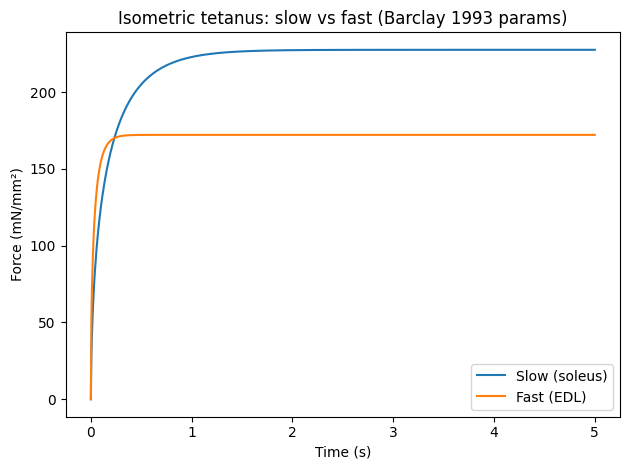

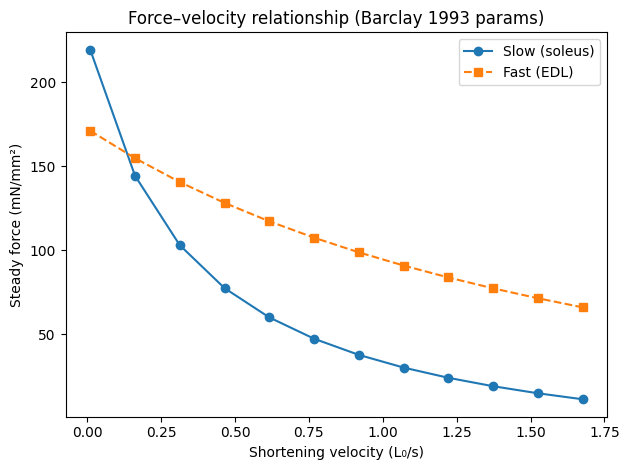

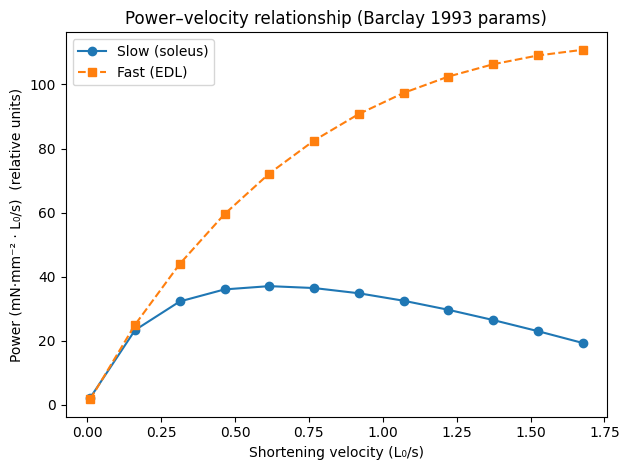

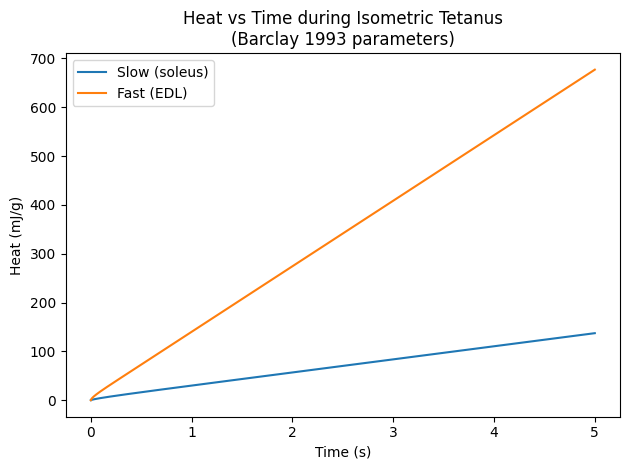

In [6]:
# ---------- 1) Isometric tetanus ----------
t_iso, L_iso, P_slow_iso, H_slow_iso, _, _ = simulate_isometric(params_slow)
_,    _, P_fast_iso, H_fast_iso, _, _      = simulate_isometric(params_fast)

plt.figure()
plt.plot(t_iso, P_slow_iso, label="Slow (soleus)")
plt.plot(t_iso, P_fast_iso, label="Fast (EDL)")
plt.xlabel("Time (s)")
plt.ylabel("Force (mN/mm²)")
plt.title("Isometric tetanus: slow vs fast (Barclay 1993 params)")
plt.legend()
plt.tight_layout()
plt.show()


# ---------- 2) Force–velocity & 3) Power–velocity ----------

# vmax for each fiber type (from Hill relation vm = P0 * b / a)
vm_slow = params_slow["P0"] * params_slow["b"] / params_slow["a"]
vm_fast = params_fast["P0"] * params_fast["b"] / params_fast["a"]

# Use a common velocity range up to 70% of the smaller vmax
v_mags = np.linspace(0.01, 0.7 * min(vm_slow, vm_fast), 12)

v_slow, F_slow, Pow_slow = simulate_force_velocity(params_slow, v_mags)
v_fast, F_fast, Pow_fast = simulate_force_velocity(params_fast, v_mags)

# Force–velocity
plt.figure()
plt.plot(v_slow, F_slow, "o-", label="Slow (soleus)")
plt.plot(v_fast, F_fast, "s--", label="Fast (EDL)")
plt.xlabel("Shortening velocity (L₀/s)")
plt.ylabel("Steady force (mN/mm²)")
plt.title("Force–velocity relationship (Barclay 1993 params)")
plt.legend()
plt.tight_layout()
plt.show()

# Power–velocity
plt.figure()
plt.plot(v_slow, Pow_slow, "o-", label="Slow (soleus)")
plt.plot(v_fast, Pow_fast, "s--", label="Fast (EDL)")
plt.xlabel("Shortening velocity (L₀/s)")
plt.ylabel("Power (mN·mm⁻² · L₀/s)  (relative units)")
plt.title("Power–velocity relationship (Barclay 1993 params)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Heat vs time: slow vs fast twitch during isometric tetanus ---
plt.figure()
plt.plot(t_iso, H_slow_iso, label="Slow (soleus)")
plt.plot(t_iso, H_fast_iso, label="Fast (EDL)")
plt.xlabel("Time (s)")
plt.ylabel("Heat (mJ/g)")
plt.title("Heat vs Time during Isometric Tetanus\n(Barclay 1993 parameters)")
plt.legend()
plt.tight_layout()
plt.show()

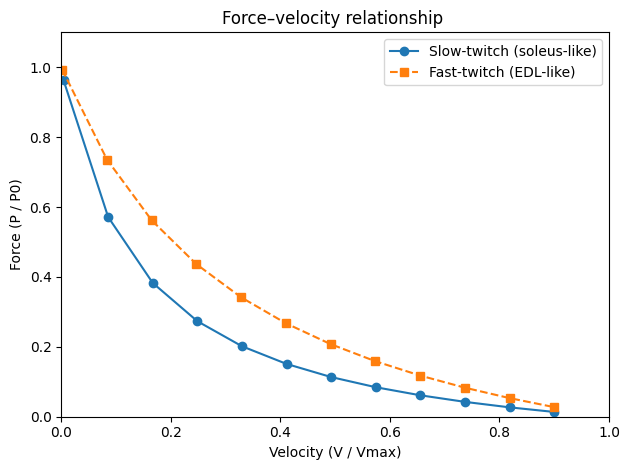

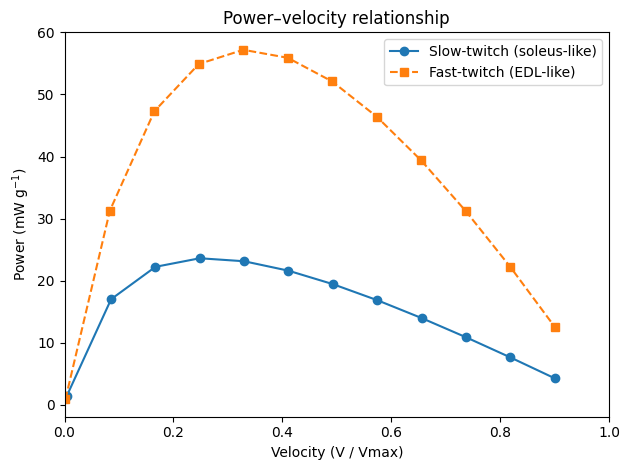

In [7]:
# ============================================================
# Barclay-style normalized force–velocity and power–velocity
#   (fixed: each fibre sampled over its own V/Vmax range)
# ============================================================

# 1) Build separate velocity ranges up to ~0.9 Vmax for each fibre
vm_slow = params_slow["P0"] * params_slow["b"] / params_slow["a"]
vm_fast = params_fast["P0"] * params_fast["b"] / params_fast["a"]

v_mags_slow = np.linspace(0.01, 0.9 * vm_slow, 12)   # absolute velocities for soleus
v_mags_fast = np.linspace(0.01, 0.9 * vm_fast, 12)   # absolute velocities for EDL

# 2) Simulate F–V for each fibre separately
v_slow, F_slow, Pow_slow = simulate_force_velocity(params_slow, v_mags_slow)
v_fast, F_fast, Pow_fast = simulate_force_velocity(params_fast, v_mags_fast)

# 3) Normalize velocity by Vmax and force by P0
vrel_slow = v_slow / vm_slow                 # V / Vmax for soleus
vrel_fast = v_fast / vm_fast                 # V / Vmax for EDL

Frel_slow = F_slow / params_slow["P0"]       # P / P0 (dimensionless)
Frel_fast = F_fast / params_fast["P0"]       # P / P0 (dimensionless)

# ---------- Force–velocity (Barclay-style: Fig. 2) ----------
plt.figure()
plt.plot(vrel_slow, Frel_slow, "o-", label="Slow-twitch (soleus-like)")
plt.plot(vrel_fast, Frel_fast, "s--", label="Fast-twitch (EDL-like)")
plt.xlabel("Velocity (V / Vmax)")
plt.ylabel("Force (P / P0)")
plt.title("Force–velocity relationship ")
plt.legend()
plt.xlim(0, 1.0)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# ---------- Power–velocity (Barclay-style: Fig. 3) ----------

# Experimental peak powers from Barclay 1993 (mouse, 21°C)
Pmax_slow_target = 23.6  # mW g^-1 (soleus peak power)
Pmax_fast_target = 57.2  # mW g^-1 (EDL peak power)

# Our Pow_* are in arbitrary P*v units; scale each fibre separately
scale_slow = Pmax_slow_target / np.max(Pow_slow)
scale_fast = Pmax_fast_target / np.max(Pow_fast)

Pow_slow_mWg = Pow_slow * scale_slow
Pow_fast_mWg = Pow_fast * scale_fast

plt.figure()
plt.plot(vrel_slow, Pow_slow_mWg, "o-", label="Slow-twitch (soleus-like)")
plt.plot(vrel_fast, Pow_fast_mWg, "s--", label="Fast-twitch (EDL-like)")
plt.xlabel("Velocity (V / Vmax)")
plt.ylabel("Power (mW g$^{-1}$)")
plt.title("Power–velocity relationship")
plt.legend()
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()


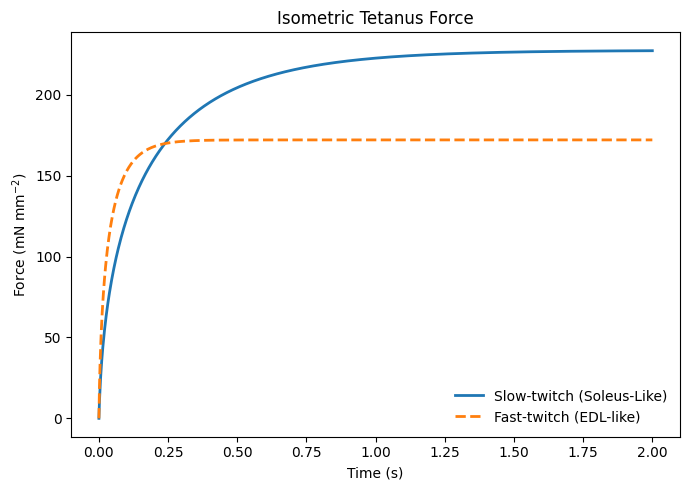

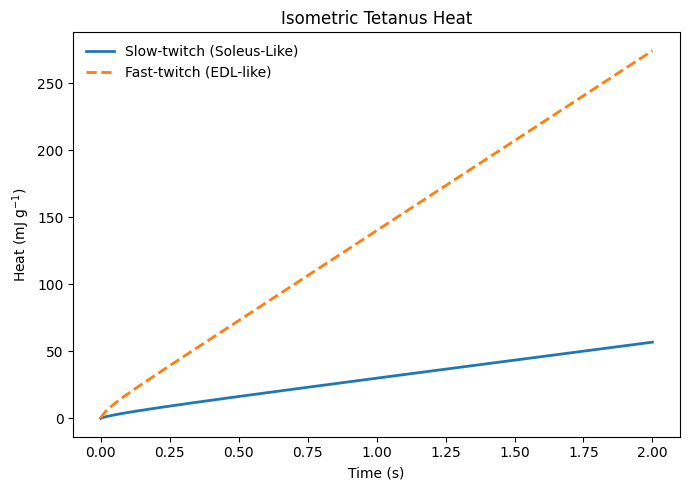

In [11]:
# ============================================================
# Barclay-style Isometric Tetanus Plots (Force & Heat vs Time)
# ============================================================

# Use the slow/fast params already defined earlier:
# params_slow, params_fast

# Simulate 5 seconds of isometric tetanus
t_iso, L_iso, P_slow_iso, H_slow_iso, _, _ = simulate_isometric(params_slow, T=2.0)
_,    _, P_fast_iso, H_fast_iso, _, _      = simulate_isometric(params_fast, T=2.0)

# ---------------------------
# 1. Force vs time (Barclay-style)
# ---------------------------
plt.figure(figsize=(7,5))
plt.plot(t_iso, P_slow_iso, label="Slow-twitch (Soleus-Like)", linewidth=2)
plt.plot(t_iso, P_fast_iso, label="Fast-twitch (EDL-like)", linewidth=2, linestyle="--")

plt.xlabel("Time (s)")
plt.ylabel("Force (mN mm$^{-2}$)")          # Barclay units
plt.title("Isometric Tetanus Force")
#plt.grid(True, linewidth=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# ---------------------------
# 2. Heat vs time (Barclay-style)
# ---------------------------
plt.figure(figsize=(7,5))
plt.plot(t_iso, H_slow_iso, label="Slow-twitch (Soleus-Like)", linewidth=2)
plt.plot(t_iso, H_fast_iso, label="Fast-twitch (EDL-like)", linewidth=2, linestyle="--")

plt.xlabel("Time (s)")
plt.ylabel("Heat (mJ g$^{-1}$)")            # Barclay units
plt.title("Isometric Tetanus Heat")

# Expected slopes:
#   ~26.8 mJ/(g·s) for soleus
#   ~134.2 mJ/(g·s) for EDL

#plt.grid(True, linewidth=0.4)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()
